In [279]:
import pandas as pd
import os
import re
import glob
from datetime import datetime
from textwrap import wrap

from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
from geopandas.tools import sjoin

from fiona.crs import from_epsg
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.patheffects as PathEffects
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import seaborn as sns
sns.set(style="darkgrid")
import pylab as P
%pylab inline

from pandas.plotting import table

Populating the interactive namespace from numpy and matplotlib


/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'box', 'datetime', 'table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Notebook for initial data processing and quick summaries

* Read data from individual years
* combine into one frame with PBA 2040 data, 
* Do some mapping 

In [321]:
# Get current fig size
fig_size = plt.rcParams["figure.figsize"]
 
# Set default figure width and height
fig_size[0] = 12
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['figure.figsize']
plt.style.use('ggplot')

drop=os.getenv('DROPBOX_LOC')
box=os.getenv('BOX_LOC')

In [322]:
## formating functions for colorbar

def comma_format(x, p):
    return format(x, "6,.0f")
def percent_format(x, p):
    return format(x*100, "6,.1f")+'%'
#comma_fmt = lambda x,pos: '{:,.0f}'.format(x)

class MidPointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

### Mappings and functions

In [6]:
countymap={1:'San Francisco',2:'San Mateo',3:'Santa Clara',4:'Alameda',5:'Contra Costa',6:'Solano',
           7:'Napa',8:'Sonoma',9:'Marin'}

## city classification from vital signs
mtc_city_classification_vs=pd.Series({'Big Three': ['San Jose', 'San Francisco', 'Oakland'],
'Bayside': ['Alameda', 'Albany', 'Atherton', 'Belmont', 'Belvedere', 'Berkeley', 'Brisbane', 'Burlingame', 'Campbell', 'Colma', 'Corte Madera', 'Cupertino', 'Daly City', 'East Palo Alto', 'El Cerrito', 'Emeryville', 'Fairfax', 'Foster City', 'Fremont', 'Hayward', 'Hercules', 'Hillsborough', 'Larkspur', 'Los Altos', 'Los Altos Hills', 'Los Gatos', 'Menlo Park', 'Mill Valley', 'Millbrae', 'Milpitas', 'Monte Sereno', 'Mountain View', 'Newark', 'Pacifica', 'Palo Alto', 'Piedmont', 'Pinole', 'Portola Valley', 'Redwood City', 'Richmond', 'Ross', 'San Anselmo', 'San Bruno', 'San Carlos', 'San Leandro', 'San Mateo', 'San Pablo', 'San Rafael', 'Santa Clara', 'Saratoga', 'Sausalito', 'South San Francisco', 'Sunnyvale', 'Tiburon', 'Union City', 'Vallejo', 'Woodside'],

'Inland, Delta and Coastal': ['American Canyon', 'Antioch', 'Benicia', 'Brentwood', 'Calistoga', 'Clayton', 'Cloverdale', 'Concord', 'Cotati', 'Danville', 'Dixon', 'Dublin', 'Fairfield', 'Gilroy', 'Half Moon Bay', 'Healdsburg', 'Lafayette', 'Livermore', 'Martinez', 'Moraga', 'Morgan Hill', 'Napa', 'Novato', 'Oakley', 'Orinda', 'Petaluma', 'Pittsburg', 'Pleasant Hill', 'Pleasanton', 'Rio Vista', 'Rohnert Park', 'San Ramon', 'Santa Rosa', 'Sebastopol', 'Sonoma', 'St. Helena', 'Suisun City', 'Vacaville', 'Walnut Creek', 'Windsor', 'Yountville'],
'Unincorporated': ['Unincorporated Alameda', 'Unincorporated Contra Costa', 'Unincorporated Marin',
                   'Unincorporated Napa', 'Unincorporated San Mateo', 'Unincorporated Santa Clara',
                   'Unincorporated Sonoma', 'Unincorporated Solano']}).apply(pd.Series).stack().reset_index(1,drop=True).reset_index(name='juris').set_index('juris')['index']

In [7]:
pct=lambda x: x/x.sum()

### Load shape files 

In [290]:
jurisdictions=gpd.read_file('/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Spatial/Jurisdictions/places_w_remainder_uninc_complete_2019_vintage.shp')
jurisdictions['juris']=jurisdictions.jurisdicti
jurisdictions.index=jurisdictions.GEOID
jurisdictions['geometry']=jurisdictions.simplify(tolerance=250)

In [291]:
taz = gpd.read_file('/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Spatial/Zones/TAZ1454/zones1454.shp').to_crs(from_epsg(3740))
taz['county']=taz.county_mtc.map(countymap)
taz=taz[taz.geometry.notnull()]
taz.head(2)

,gid,stfid,fipsstco,tract2,tract,tractid,superdistr,taz1454,arealand,areawatr,...,landacre,watracre,area,perimeter,acres,zone_id,county_mtc,gqpop,geometry,county
0,83,06001408100,06001,408100,408100,4081,18,885,8663320.0,0.0,...,2140.753085,0.0,8657645.049,17255.993,198.752,885,4,0,"POLYGON ((576130.826 4180695.798, 576060.676 4...",Alameda
1,198,06001435102,06001,435102,435102,4351.02,17,821,4329408.0,0.0,...,1069.820061,0.0,4326727.957,15311.197,99.328,821,4,1094,"POLYGON ((583506.706 4168637.018, 583512.966 4...",Alameda


In [338]:
# # relate tazs to jurisdictions

# taz_x_juris=gpd.overlay(taz,jurisdictions,how='intersection')
# taz_x_juris['area']=taz_x_juris.geometry.area

# ## largest within-juris superdistrict polygon, each juris
# taz_x_juris.groupby(['jurisdicti','superdistr']).area.sum().groupby(level=0,group_keys=False).nlargest(1).head()

In [339]:
# ## dissolve to superdist geographies

# superdist=taz.dissolve(by='superdistr').reset_index()
# superdist.plot()

### PBA Jurisdiction-level analysis

In [294]:
## which recent runs to keep for comparison?

RUNIDS=[939,56]

In [299]:
## base paths

PBA_PATH='/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Previous BayArea UrbanSim Versions/Bay Area UrbanSim One/PBA40/r7224/r7224'
BASE_PATH='/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim 1.5/PBA50/Draft Blueprint runs/Blueprint Basic (s21)'
OUTPUT_PATH='/Users/aolsen/Dropbox/Data/PBA2050'

In [300]:
## file name formating
TAZ_FORMAT='run{runid}_taz_summaries_{year}.csv'
JURIS_FORMAT='run{runid}_juris_summaries_{year}.csv'

#### Process PBA2040 data

In [301]:
jurisfiles_pba=glob.glob(os.path.join(PBA_PATH,'run*_juris_summaries_*.csv'))
jurisfiles_pba=filter(lambda x: '4_juris_summaries_2010' not in x,jurisfiles_pba)

jurisdata_pba={}
for f in jurisfiles_pba:
    
    # get year from file name - needed  for disambiguation
    yr=re.search('_(\d{4})',os.path.split(f)[-1]).group(1)
    print yr,
    this_juris=pd.read_csv(f)
    jurisdata_pba[yr]=this_juris

jurisdata_pba=pd.concat(jurisdata_pba,names=['YEAR','OID'],sort=False).reset_index()
jurisdata_pba.columns=jurisdata_pba.columns.str.lower()
jurisdata_pba.loc[jurisdata_pba.juris.str.contains('County'),'juris']='Unincorporated '+jurisdata_pba.loc[jurisdata_pba.juris.str.contains('County'),'juris'].str.replace(' County','')
jurisdata_pba['county']=jurisdata_pba.juris.map(jurisdictions.set_index('jurisdicti').county)
jurisdata_pba['city_class']=jurisdata_pba.juris.map(mtc_city_classification_vs)
jurisdata_pba['runid']='PBA2040'
jurisdata_pba=jurisdata_pba.set_index(['runid','year','county','juris','city_class']).tothh.sort_index()
jurisdata_pba.head(2)

2010 2015 2020 2025 2030 2035 2040

runid    year  county   juris    city_class
PBA2040  2010  Alameda  Alameda  Bayside       30123
                        Albany   Bayside        7401
Name: tothh, dtype: int64

#### Process PBA2050 data

In [302]:
## recursively find runs under the base folder. Keep only if in RUNID list.

jurisfiles={}
for root, dirs, files in os.walk(BASE_PATH):
    path = root.split(os.sep)
    for fn in files:
        for RUNID in RUNIDS:
            # limit the runs to load
            if str(RUNID) in fn and 'juris' in fn:
                # get year from file name - needed  for disambiguation
                year=re.search('_(\d{4})',fn).group(1)
                tmp=pd.read_csv(os.path.join(root,fn))
                
                jurisfiles[(RUNID,year)]=tmp

#### Combine PBA2040 data with new runs

In [324]:
## classify, combine, add pba2040
jurisdata_combo=pd.concat(jurisfiles,names=['runid','year','rowid']).reset_index()

jurisdata_combo.columns=jurisdata_combo.columns.str.lower()
jurisdata_combo.loc[jurisdata_combo.juris.str.contains('County'),'juris']='Unincorporated '+jurisdata_combo.loc[jurisdata_combo.juris.str.contains('County'),'juris'].str.replace(' County','')
jurisdata_combo['county']=jurisdata_combo.juris.map(jurisdictions.set_index('jurisdicti').county)
jurisdata_combo['city_class']=jurisdata_combo.juris.map(mtc_city_classification_vs)

jurisdata_combo=jurisdata_combo.set_index(['runid','year','county','juris','city_class']).tothh.sort_index()#.reset_index()
jurisdata_combo=jurisdata_combo.append(jurisdata_pba)
jurisdata_combo.head(2)

/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


runid  year  county   juris    city_class
56     2010  Alameda  Alameda  Bayside       28877
                      Albany   Bayside        7093
Name: tothh, dtype: int64

In [323]:
jurisdata_combo.unstack([1,0])[['2015','2050']].head()

year                                           2015                  2050  \
runid                                            56    939 PBA2040     56   
county  juris      city_class                                               
Alameda Alameda    Bayside                    29845  29096   33992  41727   
        Albany     Bayside                     7353   7226    7560   8299   
        Berkeley   Bayside                    46669  46516   48781  56942   
        Dublin     Inland, Delta and Coastal  17432  17563   15860  32404   
        Emeryville Bayside                     6226   6330    6818  18003   

year                                                 
runid                                           939  
county  juris      city_class                        
Alameda Alameda    Bayside                    39996  
        Albany     Bayside                     7947  
        Berkeley   Bayside                    53713  
        Dublin     Inland, Delta and Coastal  31393  
        Emeryville Bayside                    14006

In [325]:
## write out to csv for r plotting
jurisdata_combo.reset_index().to_csv(os.path.join(OUTPUT_PATH,'pba50_tothh_combo.csv'))

### Load TAZ-level data

In [326]:
## vars to keep
EMPVARS=[u'AGREMPN', u'FPSEMPN', u'HEREMPN', u'RETEMPN', u'MWTEMPN', u'OTHEMPN','TOTEMP']
POPVARS=['TOTHH','TOTPOP','HHPOP']
IDVARS=['runid','year','TAZ','COUNTYNAME','SD']

In [ ]:
emp_controls=pd.read_csv('https://raw.githubusercontent.com/BayAreaMetro/regional_forecast/master/to_baus/s21/employment_controls_s21.csv',index_col='year')
emp_controls.columns=emp_controls.columns.str.upper()

In [336]:
## growth by sector
emp_controls.loc[2050]/emp_controls.loc[2015]

AGREMPN    1.211376
FPSEMPN    1.483606
HEREMPN    1.424309
MWTEMPN    1.045265
OTHEMPN    1.361133
RETEMPN    1.238104
dtype: float64

In [328]:
## recursively find runs under the base folder. Keep only if in RUNID list.

tazfiles={}
timestamps={}
for root, dirs, files in os.walk(BASE_PATH):
    path = root.split(os.sep)
    #print((len(path) - 1) * '---', os.path.basename(root))
    for fn in files:
        for RUNID in RUNIDS:
            if str(RUNID) in fn and 'taz' in fn:
                
                ## get year from file name - needed  for disambiguation
                year=int(re.search('_(\d{4})',fn).group(1))
                
                ## get timestamps to be able to get the most recent (runid 56 is actually after 939)
                timestamps[(year,RUNID)]=datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(root,fn)) )
                tmp=pd.read_csv(os.path.join(root,fn))
                
                tazfiles[(RUNID,year)]=tmp
tazdata=pd.concat(tazfiles,names=['runid','year'])#.rename(columns=lambda x: x.lower())
tazdata['COUNTYNAME']=tazdata.COUNTY.map(countymap)    
tazdata=tazdata.reset_index()
tazdata.head(3)

,runid,year,level_2,TAZ,SD,ZONE,COUNTY,AGREMPN,FPSEMPN,HEREMPN,...,hh_size_3,hh_size_4_plus,county,hh_wrks_0,hh_wrks_1,hh_wrks_2,hh_wrks_3_plus,hh_kids_no,hh_kids_yes,COUNTYNAME
0,56,2010,0,1,1,1,1,21.0,10636.0,518.0,...,2.0,0.0,1.0,19.0,29.0,6.0,2.0,52.0,4.0,San Francisco
1,56,2010,1,2,1,2,1,54.0,16396.0,1147.0,...,19.0,15.0,1.0,53.0,75.0,12.0,2.0,132.0,10.0,San Francisco
2,56,2010,2,3,1,3,1,3.0,449.0,522.0,...,18.0,13.0,1.0,101.0,141.0,23.0,5.0,250.0,20.0,San Francisco


In [309]:
## most recent run for each year?

most_recent=pd.Series(timestamps).to_frame('stamp').groupby(level=0,group_keys=False).stamp.nlargest(1)
most_recent

2010  2010  56   2020-06-05 13:30:41
2015  2015  56   2020-06-05 13:58:05
2020  2020  56   2020-06-05 14:23:13
2025  2025  56   2020-06-05 14:44:08
2030  2030  56   2020-06-05 15:08:52
2035  2035  56   2020-06-05 15:34:35
2040  2040  56   2020-06-05 16:01:22
2045  2045  56   2020-06-05 16:31:31
2050  2050  56   2020-06-05 17:09:20
Name: stamp, dtype: datetime64[ns]

In [329]:
RECENT_RUN=most_recent.index.get_level_values(2).unique()[0]

In [330]:
## compare with emp control totals 
## bug in header names - switched
tazdata.groupby(['runid','year'])[EMPVARS].sum().loc[RECENT_RUN]/emp_controls

,AGREMPN,FPSEMPN,HEREMPN,MWTEMPN,OTHEMPN,RETEMPN,TOTEMP
year,,,,,,,
2010,1.0,0.686340,0.629192,1.457003,1.166278,1.362745,NaN
2015,1.0,0.581486,0.711021,1.719733,0.423394,3.321795,NaN
2020,1.0,0.554596,0.833461,1.803115,0.384351,3.121668,NaN
2025,1.0,0.513907,0.743162,1.945876,0.358986,3.748335,NaN
2030,1.0,0.477685,0.693510,2.093431,0.381640,3.778271,NaN
2035,1.0,0.454874,0.684853,2.198411,0.382161,3.820814,NaN
2040,1.0,0.437514,0.683348,2.285640,0.386163,3.789550,NaN
2045,1.0,0.422758,0.680376,2.365419,0.386585,3.801944,NaN
2050,1.0,0.409682,0.679483,2.440918,0.385125,3.821376,NaN


### Turn TAZ data into spatial frame

In [331]:
## format multiple years- keep wide format which works well as shapefile
tazdata_wide=tazdata.set_index(IDVARS).loc[RECENT_RUN,EMPVARS+POPVARS].unstack('year').swaplevel(1,0,axis=1)
tazdata_wide=tazdata_wide.join(pd.concat([(tazdata_wide[2050]-tazdata_wide[2010]).stack()],keys=['GROWTH10_50'],names=['year','TAZ','COUNTYNAME','SD','variable']).unstack(['year','variable']))
tazdata_wide=tazdata_wide.GROWTH10_50.reset_index()
tazdata_wide.head()

,TAZ,COUNTYNAME,SD,AGREMPN,FPSEMPN,HEREMPN,RETEMPN,MWTEMPN,OTHEMPN,TOTEMP,TOTHH,TOTPOP,HHPOP
0,1,San Francisco,1,10.0,1001.0,7788.0,-1183.0,-307.0,-357.0,6952.0,-2.0,-8.0,-11.0
1,2,San Francisco,1,8.0,-1223.0,10728.0,-3222.0,-421.0,-272.0,5598.0,-1.0,-9.0,-19.0
2,3,San Francisco,1,5.0,955.0,1553.0,-210.0,32.0,188.0,2523.0,8.0,-4.0,-22.0
3,4,San Francisco,1,-6.0,4218.0,9588.0,-3047.0,-853.0,-59.0,9841.0,25.0,20.0,15.0
4,5,San Francisco,1,9.0,2968.0,5286.0,749.0,486.0,1098.0,10596.0,86.0,84.0,48.0


In [332]:
## add TAZ geometries
tazdata_wide['geometry']=tazdata_wide.TAZ.map(taz.set_index('zone_id').geometry)
tazdata_geo=gpd.GeoDataFrame(tazdata_wide,crs=from_epsg(3740)).reset_index()
tazdata_geo['area']=tazdata_geo.geometry.area
tazdata_geo.head(2)

,index,TAZ,COUNTYNAME,SD,AGREMPN,FPSEMPN,HEREMPN,RETEMPN,MWTEMPN,OTHEMPN,TOTEMP,TOTHH,TOTPOP,HHPOP,geometry,area
0,0,1,San Francisco,1,10.0,1001.0,7788.0,-1183.0,-307.0,-357.0,6952.0,-2.0,-8.0,-11.0,"POLYGON ((552854.916 4182932.377, 552836.594 4...",82010.143610
1,1,2,San Francisco,1,8.0,-1223.0,10728.0,-3222.0,-421.0,-272.0,5598.0,-1.0,-9.0,-19.0,"POLYGON ((552854.916 4182932.377, 552873.166 4...",125828.752752


### Basic maps

In [333]:
## some counties are wider - use portrait for those
map_orientation={'Marin':[11,17],
 'Contra Costa':[17,11],
 'Solano':[17,11],
 'Alameda':[17,11],
 'Napa':[11,17],
 'Santa Clara' :[17,11],
 'San Francisco':[11,17],
 'San Mateo':[11,17],
 'Sonoma':[11,17]}

In [310]:
# bbox_cnty={'San Francisco':[0.02, 0.5, 0.2, 0.6],
#           'San Mateo':[0.02, 0.02, 0.45, 0.45],
#           'Santa Clara':[0.02, 0.02, 0.25, 0.25],
#           'Solano':[0.02, 0.7, 0.25, 0.85],
#           'Sonoma':[0.02, 0.02, 0.25, 0.25],
#           'Napa':[0.02, 0.02, 0.25, 0.25],
#           'Marin':[0.02, 0.02, 0.25, 0.25],
#           'Contra Costa':[0.02, 0.02, 0.25, 0.25],
#           'Alameda':[0.02, 0.02, 0.25, 0.25]}

In [340]:
def map_growth(map_column='TOTHH',
                    use_discrete=True,file_slug='',map_title='',label=False,label_threshold=1000):
    
    
    with PdfPages(os.path.join(OUTPUT_PATH,'urbansim_tazmap%s_run_%s.pdf'%(map_column,RECENT_RUN))) as pdf:

        ## loop through counties - one page for each
        for cntyname in tazdata_geo.COUNTYNAME.unique():
            
            this_tazdata_geo=tazdata_geo[tazdata_geo.COUNTYNAME==cntyname]
            
            cmap=cm.coolwarm
            vmin=this_tazdata_geo[map_column].min()
            vmax=this_tazdata_geo[map_column].max()

            if use_discrete:
                ## discrete colorbar
                bounds = np.linspace(vmin,vmax,8)
                #bounds=np.arange(np.round(vmin,decimals=1),np.round(vmax,decimals=1),.025)
                norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256) 
            else:
                norm=MidPointNormalize(vmin,vmax, midpoint=this_tazdata_geo[this_tazdata_geo.COUNTYNAME==cntyname][map_column].median())


            ## instantiate plot - some counties work better for landscape so we set the figsize accordingly
            fig, ax = plt.subplots(figsize=map_orientation[cntyname])
            
            # try a grid layout with a plot  on the bottom
            #  fig= plt.figure(constrained_layout=True,figsize=map_orientation[cntyname])
            #  widths = [1]
            #  heights = [4,1]
            
            #spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig,width_ratios=widths,
            #                         height_ratios=heights)
            
            #ax = fig.add_subplot(spec[0,0])
            #ax1 = fig.add_subplot(spec[1])

            ## we set legend to false and add colorbar later
            this_tazdata_geo.plot(column=map_column,edgecolor='black',linewidth=.31,#cmap=cmap,
                                  legend=False,norm=norm,cmap=cmap,
                                 ax=ax)

            ## add jurisdiction boundaries
            #jurisdictions[jurisdictions.county==cntyname].plot(color='none',edgecolor='black',linewidth=.31,ax=ax)

            this_tazdata_geo['coords'] = this_tazdata_geo['geometry'].apply(lambda x: x.representative_point().coords[:])
            this_tazdata_geo['coords'] = [coords[0] for coords in this_tazdata_geo['coords']]

            ## add taz-level labels
            ## only include labels if growth above a threshold OR if TAZ is large so less clutter
            if label:
                for idx, row in this_tazdata_geo.loc[(this_tazdata_geo[map_column]>label_threshold)
                                                    |(this_tazdata_geo.area>this_tazdata_geo.area.quantile(.95))].iterrows():


                    plt.annotate(s='{:,.1f}'.format(row[map_column]/1000.),color='black', xy=row['coords'],
                                 horizontalalignment='center',size=10 if cntyname!='Santa Clara' else 8,
                                path_effects=[PathEffects.withStroke(linewidth=2, foreground="white")]
                                )

            ## add colorbar
            cbar=fig.colorbar(ax.collections[0],format=FuncFormatter(comma_format), 
                         orientation='horizontal',shrink=.85,#anchor = (1.5, 4), 
                         aspect=40,pad=.0125,ax=ax)
            cbar.ax.tick_params(labelsize=12)
            
            ## remove clutter
            ax.axis('off')
            ax.set_aspect('equal','box')
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])

            title('Growth in %s, 2010-2050\n%s\nLabels show growth in 1,000\'s'%(map_column,cntyname))

            t = 'PBA DRAFT growth per RUNID {runid:,.0f}. The map is prepared for informational purposes only. Labels shown if growth is larger than {threshold:,}, or, the largest TAZs. Prepared {date:%Y-%m-%d, %H:%M:%S}'.format(threshold=label_threshold,
            runid=RECENT_RUN,
            date=datetime.datetime.now()) 
            t="\n".join(wrap(t,30))
            plt.text(0.82, .91, t,  style='oblique', ha='left',
             va='top', wrap=False, withdash=True,rotation=0, 
                     transform=ax.transAxes,bbox=dict(facecolor='lightgrey', alpha=0.75,
                                                          boxstyle="round,pad=0.4"))

            ## Add table

#             tbldata=jurisdata_combo.loc(0)[RECENT_RUN,map(str,range(2010,2051,10)),cntyname].\
#                       sum(level=['year','city_class']).apply(lambda x: '{:,}'.format(x)).unstack(0)
#             tbl=table(ax,tbldata,colWidths=np.repeat(.09,tbldata.shape[1]),
#             #loc='top right',
#                       bbox = bbox_cnty[cntyname],#colWidths=[]
#                       #colLabels=['Year',map_column]#,colWidths=[0.05, 0.05]
#                      )

#             # iterate through cells of a table
#             table_props = tbl.properties()
#             table_cells = table_props['child_artists']
#             for cell in table_cells: 
#                     cell.get_text().set_fontsize(11)
#                     cell.get_text().set_color('grey')

            
            #tbldata.plot(ax=ax1)
            #plt.tight_layout(pad=0)

            pdf.savefig(facecolor=fig.get_facecolor(),box_inches='tight',
                        rasterised=False)

/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


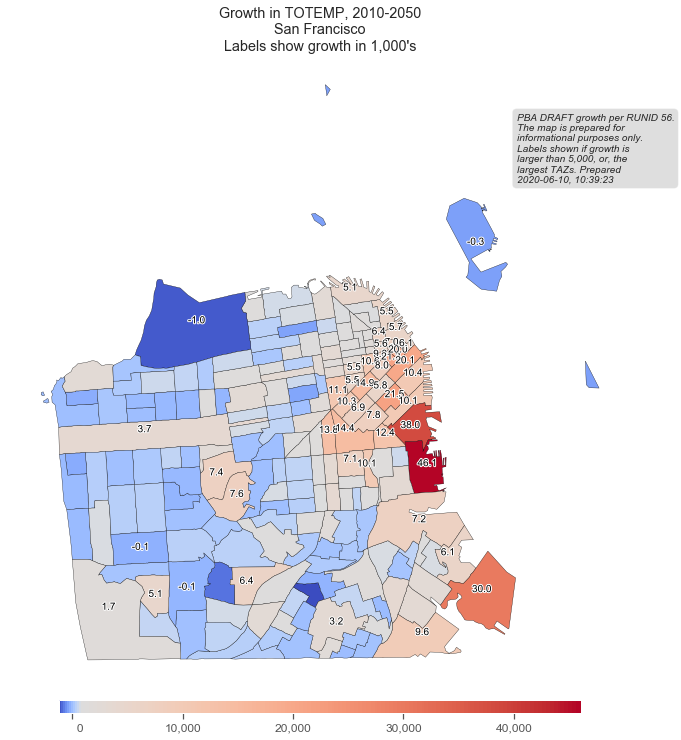

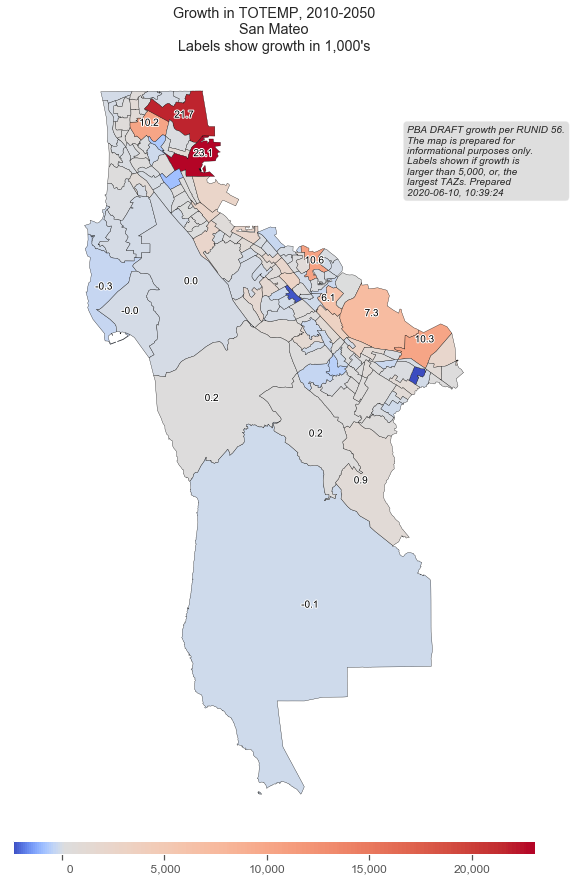

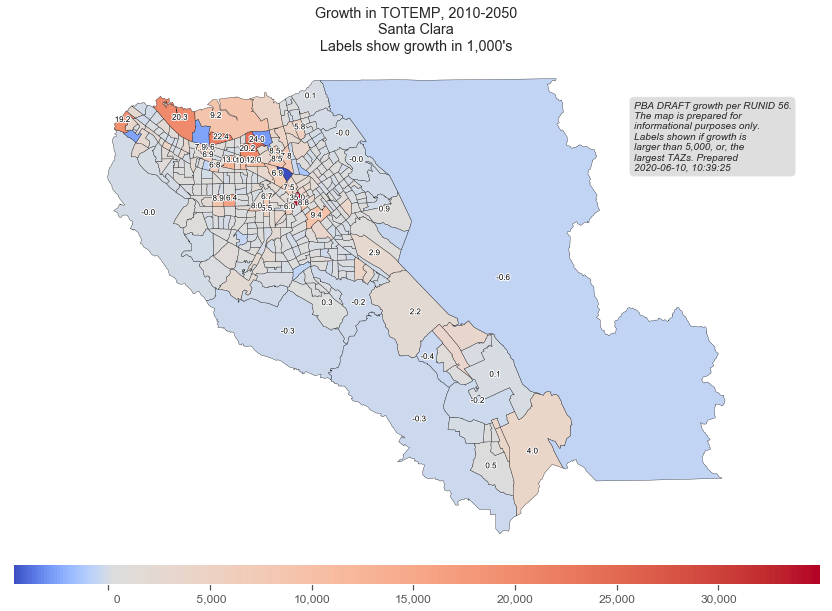

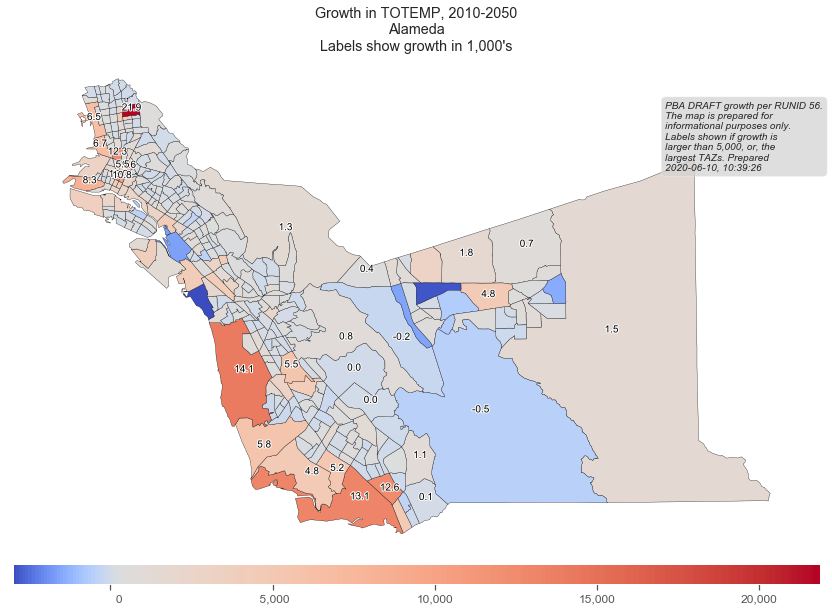

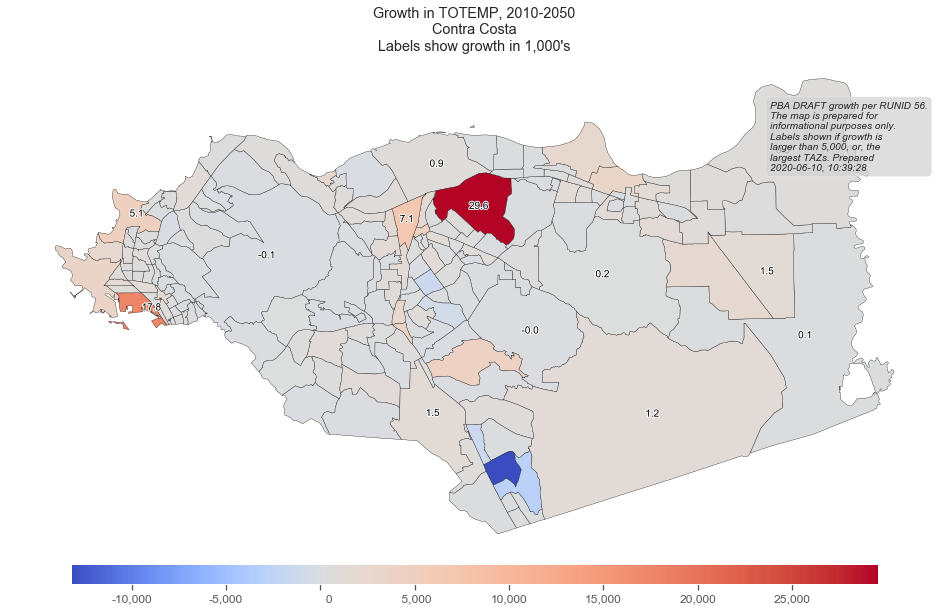

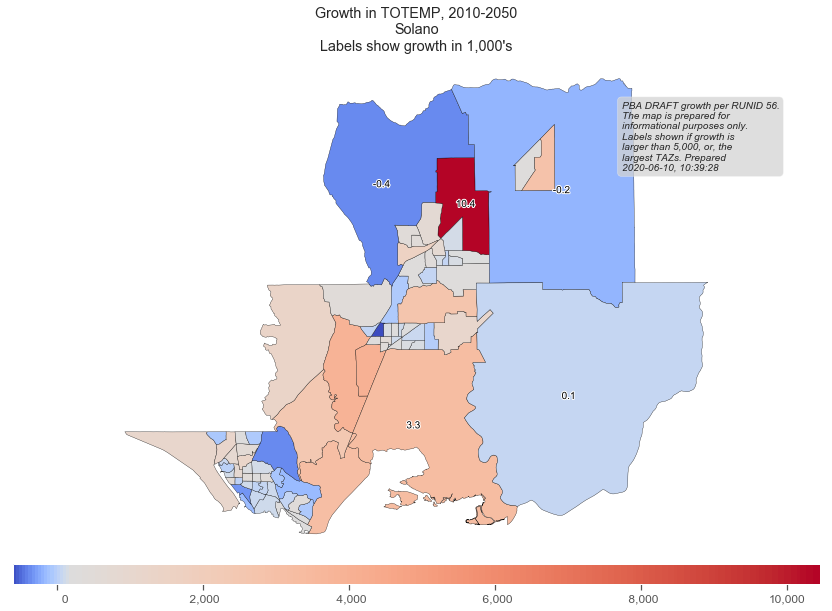

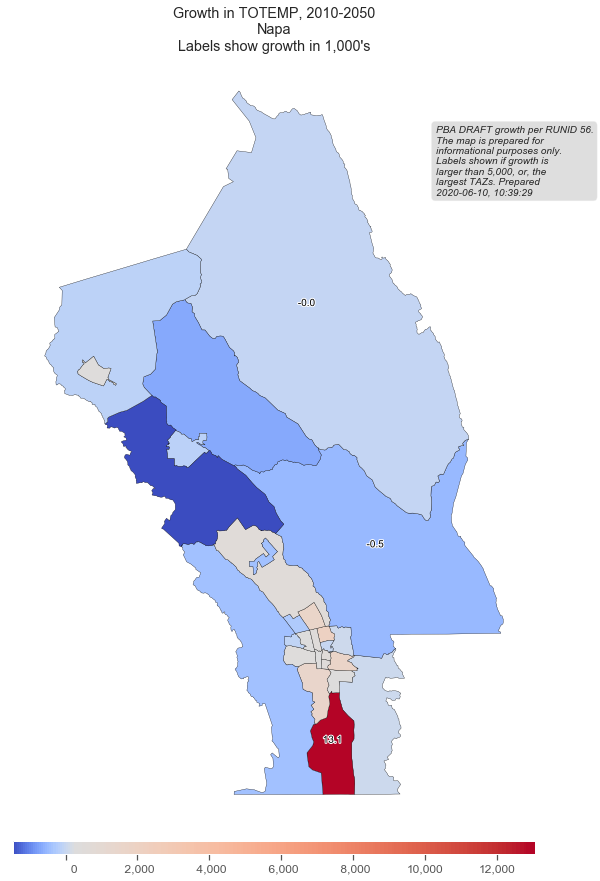

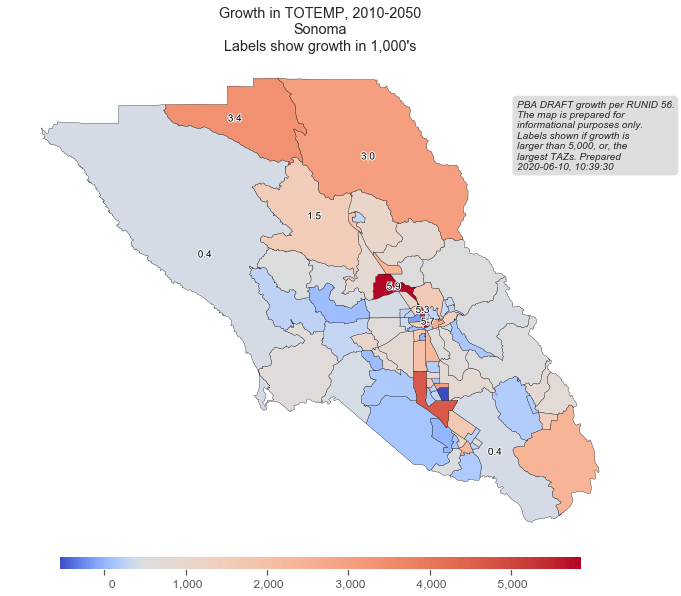

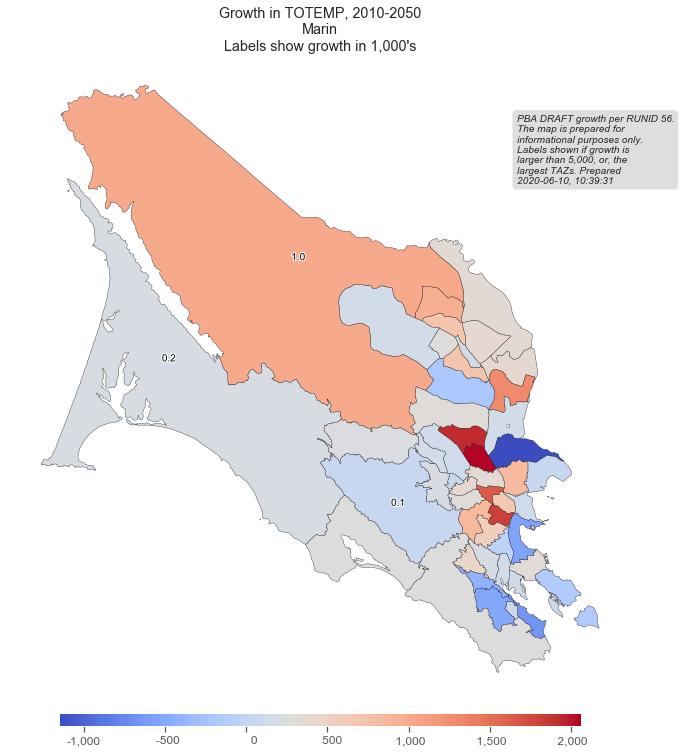

In [312]:
map_growth(map_column='TOTEMP',use_discrete=False,label=True,label_threshold=5000)

/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


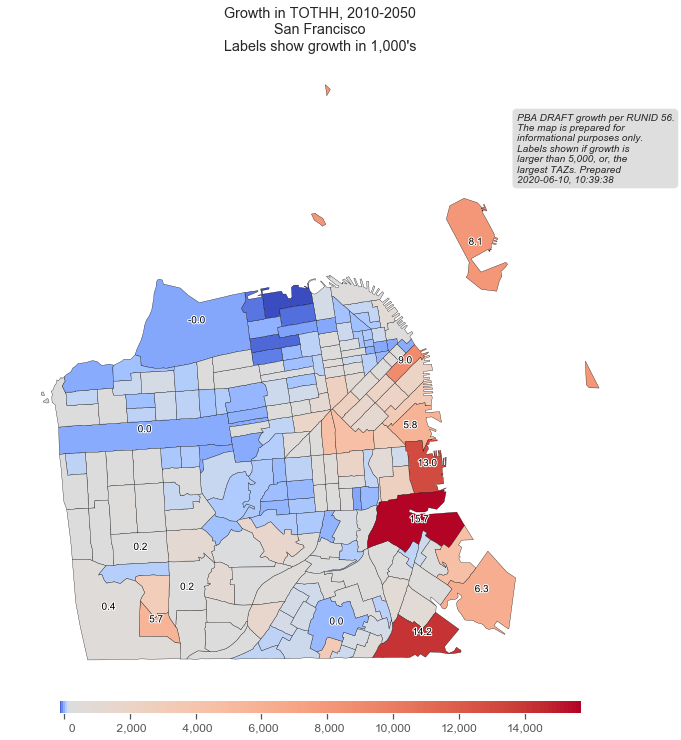

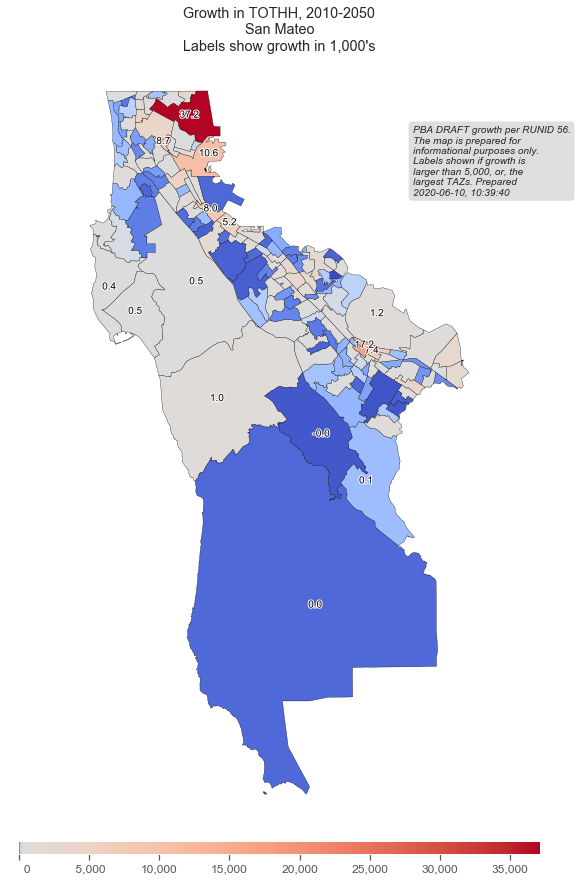

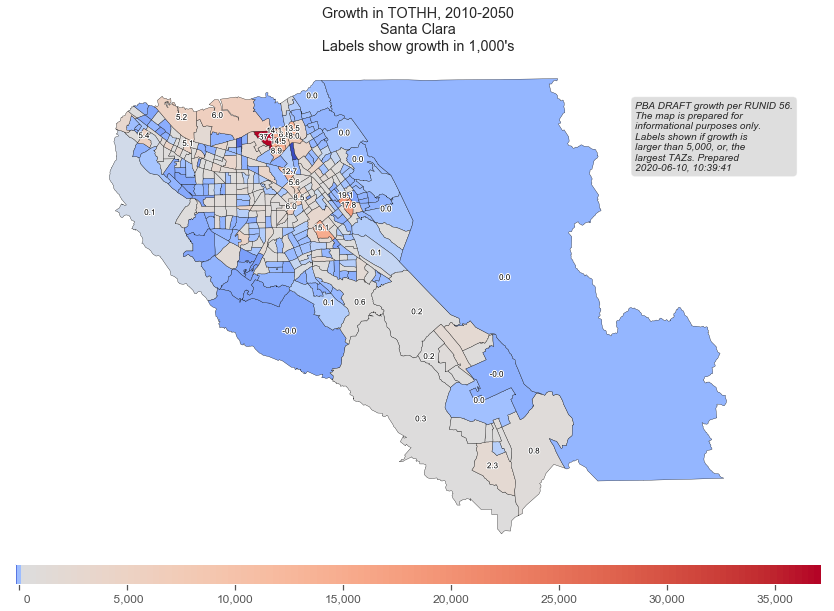

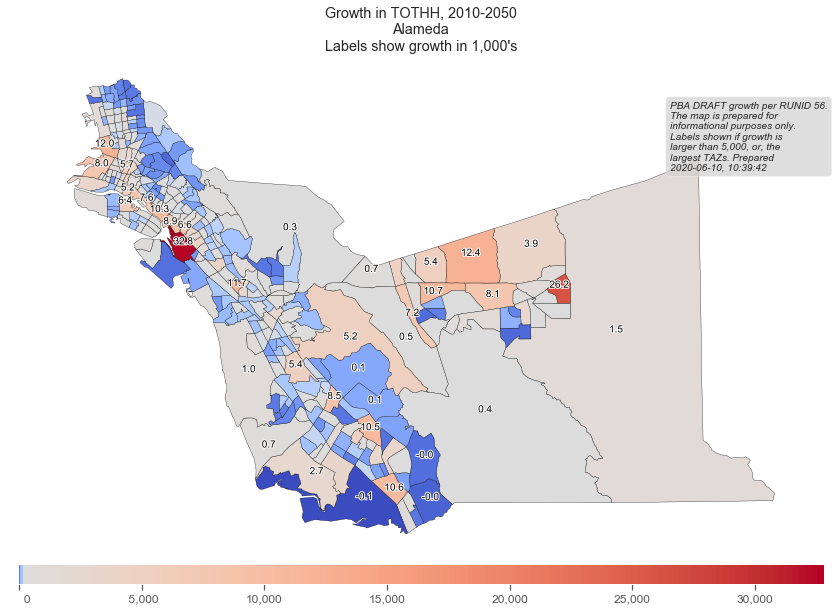

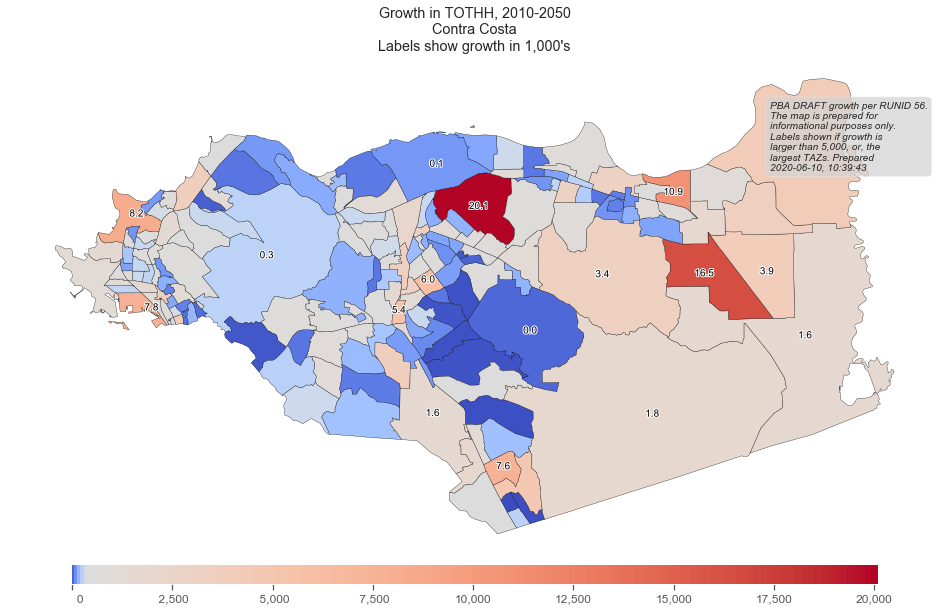

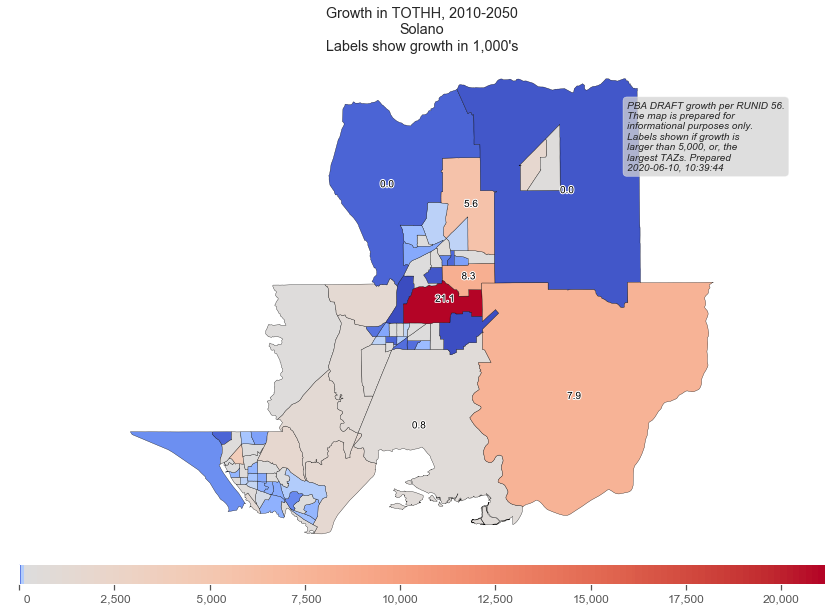

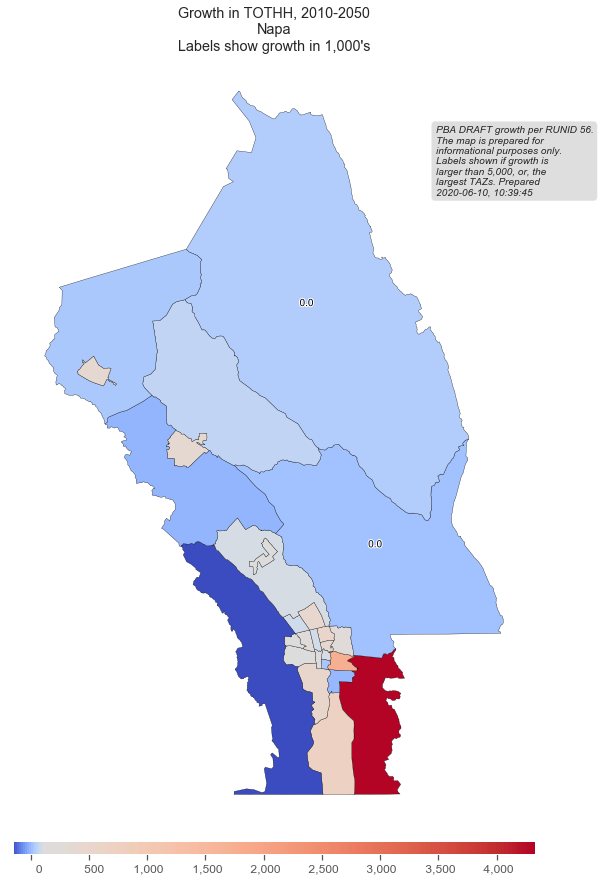

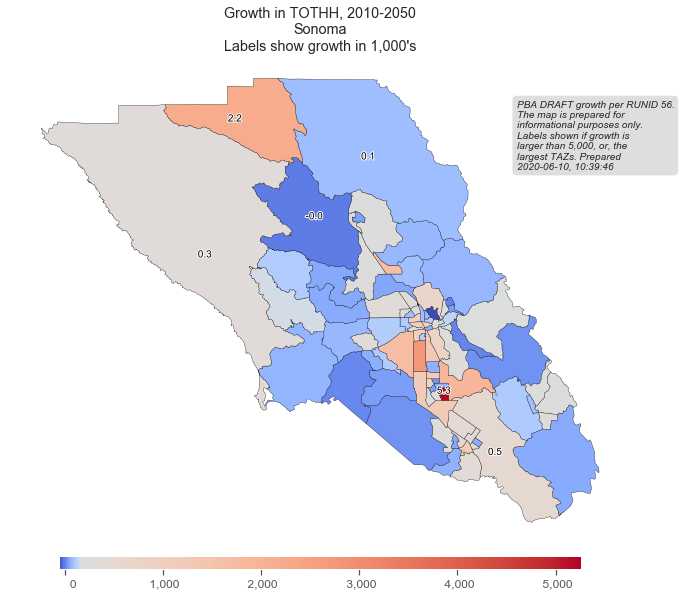

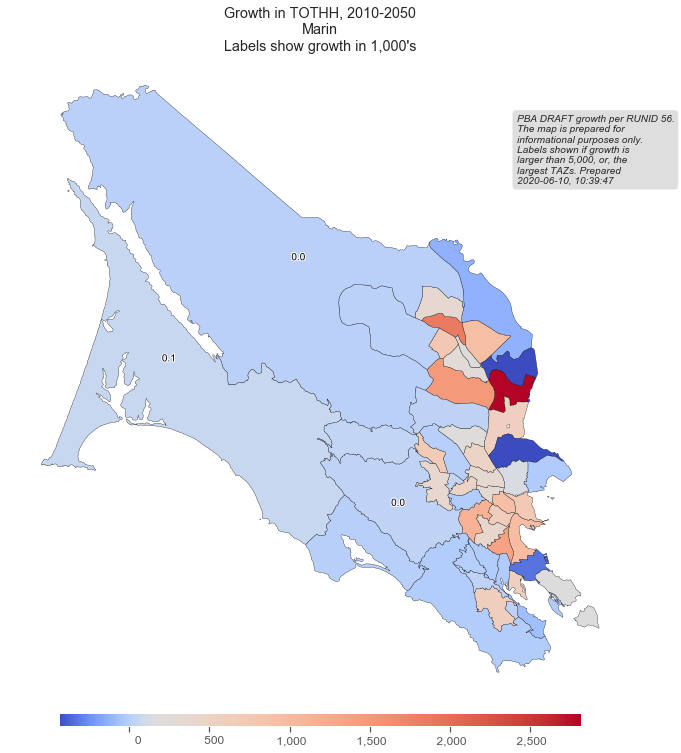

In [313]:
map_growth(map_column='TOTHH',use_discrete=False,label=True,label_threshold=5000)

### Spit out basic spreadsheet

In [234]:
## https://xlsxwriter.readthedocs.io/example_chart_clustered.html

from xlsxwriter.workbook import Workbook

## tentative candidate
writer = pd.ExcelWriter(os.path.join(OUTPUT_PATH,'PBA2050_city_class.xlsx'), engine='xlsxwriter')
# Access the XlsxWriter workbook and worksheet objects from the dataframe.
workbook = writer.book


output_df=jurisdata_combo.sum(level=['runid','year','city_class']).unstack(2)
for nme, dta in output_df.groupby(level=['runid']):
    #this_variant=re.findall('(RED|HJC|BAL)',nme)[0] if len(re.findall('(RED|HJC|BAL)',nme))==1 else 'none'
    #this_existing='%s Existing\nDist.'%this_variant
    
    #print dta3.index.get_level_values(1)#dta3[income_cat_names].head(2)
    nme2='run_%s'%nme
    dta.to_excel(writer,nme2)
    worksheet=workbook.get_worksheet_by_name(nme2)

    #workbook.close()

    # Create a new chart object
    chart = workbook.add_chart({'type': 'column'})

    chart.add_series({
        'name':'Bayside',
        'categories': '={}!$A$2:$B$10'.format(nme2),
        'values':     '={}!$C$2:$C$10'.format(nme2),
    })

    chart.add_series({
                'name':'Big Three',
        'categories': '={}!$A$2:$B$10'.format(nme2),
        'values':     '={}!$D$2:$D$10'.format(nme2),
    })

    chart.add_series({
                'name':'Inland, Delta and Coastal',
        'categories': '={}!$A$2:$B$10'.format(nme2),
        'values':     '={}!$E$2:$E$10'.format(nme2),
    })

    chart.add_series({
         'name':'Unincorporated',
        'categories': '={}!$A$2:$B$10'.format(nme2),
        'values':     '={}!$F$2:$F$10'.format(nme2),
    })

    # Set the Excel chart style.
    chart.set_style(34)
    chart.set_size({'width': 720, 'height': 576})
    chart.set_title({'name': 'UrbanSim %s'%nme2})

    # Turn off the legend.
    #chart.set_legend({'position': 'none'})

    # Insert the chart into the worksheet.
    worksheet.insert_chart('H8', chart)
    
for nme, dta in output_df.groupby(level=['runid']):
workbook.close()

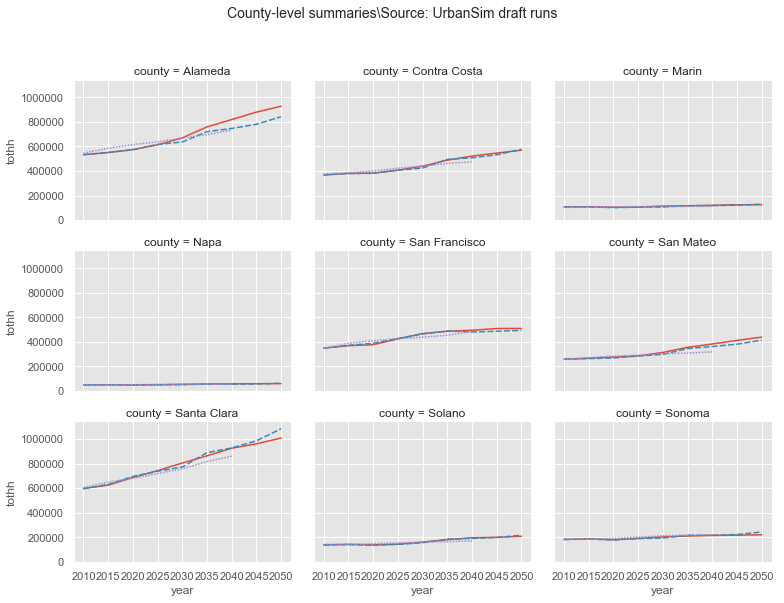

In [319]:
g = sns.relplot(x="year", y="tothh",col_wrap=3,legend=False,

                 col="county", hue="runid", style="runid",

                 kind="line", data=jurisdata_combo.sum(level=['runid','year','county']).reset_index())
g.fig.set_size_inches([11,8.5])
plt.tight_layout(rect=[0,0,1,.9])
plt.suptitle('County-level summaries\Source: UrbanSim draft runs',size=14)
savefig(os.path.join(OUTPUT_PATH,'PBA2050_county.pdf'))